In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import datetime
import os, sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

from tqdm import tqdm
import glob
from PIL import Image

### **Google Drive linking and other operations for saving some data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH_DRIVE = '/content/drive/My Drive/UNIMORE/cGAN' # Path on Google Drive where to save data (trained models and generation samples)

Mounted at /content/drive


In [ ]:
verbose = False
torch.manual_seed(1)
NOISE_VECTOR_DIM = 100
MODEL_NAME = 'ConditionalGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists(PATH_DRIVE + '/samples'):
  os.makedirs(PATH_DRIVE + '/samples')

if not os.path.exists(PATH_DRIVE + '/samples/gif_dir'):
  os.makedirs(PATH_DRIVE + '/samples/gif_dir')

if not os.path.exists(PATH_DRIVE + '/training_models'):
  os.makedirs(PATH_DRIVE + '/training_models')

if not os.path.exists(PATH_DRIVE + '/training_models/Discriminator'):
  os.makedirs(PATH_DRIVE + '/training_models/Discriminator')

if not os.path.exists(PATH_DRIVE + '/training_models/Generator'):
  os.makedirs(PATH_DRIVE + '/training_models/Generator')

# **Project start**

In [ ]:
def to_onehot(x, num_classes=10):
  '''
  One-Hot encoding of MNIST classes to use as model input (with noise vector).

  returns:
    - one-hot encoding of input vector with class labels.
  '''
  assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
  if isinstance(x, int):
    c = torch.zeros(1, num_classes).long()
    c[0][x] = 1
  else:
    x = x.cpu()
    c = torch.LongTensor(x.size(0), num_classes)
    c.zero_()
    c.scatter_(1, x, 1) # dim, index, src value
  return c


def get_sample_images(G, num_samples):
  '''
  Generate num_samples noise vector from latent space and pass to Generator
  as input in order to get sample images.

  returns:
    num_samples generate images
  '''
  samples_per_line = int(np.sqrt(num_samples))
  matrix_img = np.zeros([28 * samples_per_line, 28 * samples_per_line])
  #img = np.zeros([280, 280])
  for j in range(10):
    c = torch.zeros([10, 10]).to(DEVICE)
    c[:, j] = 1
    z = torch.randn(samples_per_line, NOISE_VECTOR_DIM).to(DEVICE)
    y_hat = G(z,c).view(samples_per_line, 28, 28)
    result = y_hat.cpu().data.numpy()
    matrix_img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
  return matrix_img
    

def make_gif(frame_folder, duration):
  '''
  Make a gif from generated samples during the training in order to see
  the improvement of the generator.

  returns:
    save a gif on google drive directory
  '''
  a = [image for image in glob.glob(f"{frame_folder}/*.jpg")]
  imgs = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.jpg")]
  for i in range(len(imgs)):
    plt.imshow(imgs[i], cmap='gray')
    plt.axis('off')
    plt.title('epoch: {}'.format(int(i* 150/len(imgs))))
    plt.savefig(frame_folder + 'gif_dir/img_%d.jpg' % int(i* 150/len(imgs)))


  a = [image for image in glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg")]
  frames = [Image.open(image) for image in glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg")]
  print('frames: {}'.format(len(frames)))
  frame_one = frames[0]
  frame_one.save(PATH_DRIVE + "/training_improvements.gif", format="GIF",
              append_images=frames, save_all=True, duration=duration, loop=0)

### **Dataset loading and preparation**

In [ ]:
#MNIST dataset preparation
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
                              )

mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
batch_size = 64
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)


condition_size = 10

In [ ]:
class Generator(nn.Module):
  '''
  Generator model definition.
  In the Conditional GAN it is defined as an MLP model with input size equal to noise vector
  plus the 10-class one-ho-encoding vector.
  The output size is the same as images we want to generate.
  '''
  def __init__(self, input_size=NOISE_VECTOR_DIM, condition_size=10, output_size=784):
    super(Generator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(input_size+condition_size, 128),
        nn.LeakyReLU(0.2),
        nn.Linear(128, 256),
        nn.BatchNorm1d(256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, output_size),
        nn.Tanh() #The tanh activation at the output layer ensures that the pixel 
                #values are mapped in line with its own output, i.e., between (-1, 1)
    )

 
  def forward(self, x, c):
    x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
    noise_vector_with_class = torch.cat((x, c), 1) # noise_vector_with_class: [input, label] concatenated vector
    generated_img = self.model(noise_vector_with_class)
    generated_img = generated_img.view(x.size(0), 1, 28, 28)
    return generated_img

In [ ]:
class Discriminator(nn.Module):
  '''
  Discriminator model definition as a binary classifier.
  In the Conditional GAN it is defined as an MLP model with input size equal to
  flattened image size plus the one-hot-ecnoding.
  The output size is the 1 (i.e. the probability of a binary problem -> real or fake).
  '''
  def __init__(self, input_size=784, condition_size=10, num_classes=1):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(input_size+condition_size, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, num_classes),
        nn.Sigmoid(), #The final layer has the sigmoid activation function, 
                    #which squashes the output value between 0 (fake) and 1 (real).
    )


  def forward(self, x, c):        
    x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
    image_flattened_with_class = torch.cat((x, c), 1) # image_flattened_with_class: [input, label] concatenated vector
    result = self.model(image_flattened_with_class)
    return result

## **Training phase**

In [ ]:
#Models creation
num_samples = 100
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

#Loss function
adversarial_loss  = nn.BCELoss()

#Optimizer
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
max_epoch = 150 # epochs for training
step = 0
step_frequency = 7000 #frequency to save training samples in order to see G's improvements
n_critic = 1 # for training more k steps about Discriminator

D_loss_history = []
G_loss_history = []

D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

for epoch in tqdm(range(max_epoch), desc='cGAN training'):
  for idx, (real_images, labels) in enumerate(data_loader):
    # Training Discriminator
    x = real_images.to(DEVICE)
    y = labels.view(batch_size, 1)
    y = to_onehot(y).to(DEVICE)
    x_outputs = D(x, y)
    D_x_loss = adversarial_loss(x_outputs, D_labels)

    z = torch.randn(batch_size, NOISE_VECTOR_DIM).to(DEVICE)
    z_outputs = D(G(z, y), y)
    D_z_loss = adversarial_loss(z_outputs, D_fakes)
    D_loss = D_x_loss + D_z_loss
    
    D.zero_grad()
    D_loss.backward()
    D_optimizer.step()
    
    if step % n_critic == 0:
      # Training Generator
      z = torch.randn(batch_size, NOISE_VECTOR_DIM).to(DEVICE)
      z_outputs = D(G(z, y), y)
      G_loss = adversarial_loss(z_outputs, D_labels)

      G.zero_grad()
      G_loss.backward()
      G_optimizer.step()
    
    if verbose:
      if step % 500 == 0:
        print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
    
    if step % step_frequency == 0:
      G.eval()
      img = get_sample_images(G, num_samples)
      imsave(PATH_DRIVE + '/samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
      G.train()

    step += 1

  D_loss_history.append(D_loss.item())
  G_loss_history.append(G_loss.item())

  torch.save(G.state_dict(), PATH_DRIVE + '/training_models/Generator/G_epoch_%d.pth' % (epoch))
  torch.save(D.state_dict(), PATH_DRIVE + '/training_models/Discriminator/D_epoch_%d.pth' % (epoch))

cGAN training: 100%|██████████| 150/150 [44:11<00:00, 17.67s/it]


## **Post training operations**

### **Plotting Generator and Discriminator's losses**

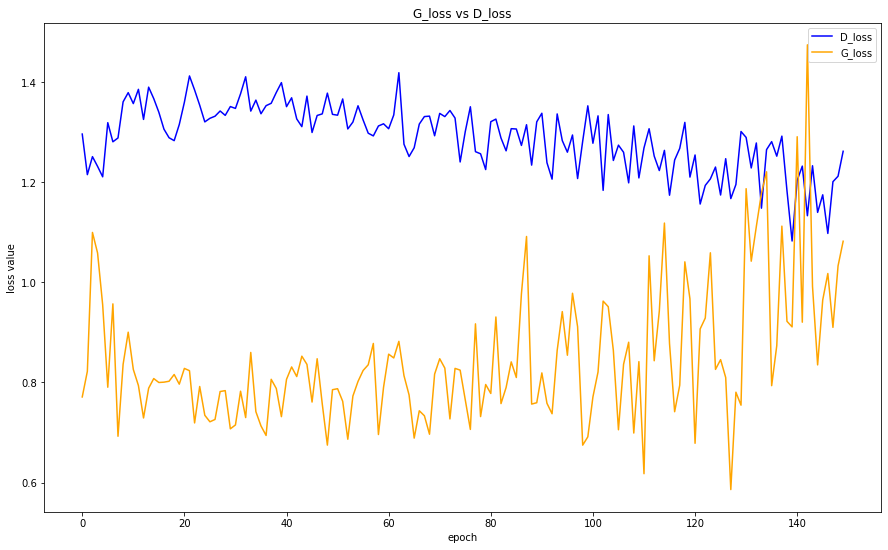

In [ ]:
plt.figure(figsize=(15,9)) 
plt.plot(D_loss_history, color='blue', label='D_loss') #plot the data
plt.plot(G_loss_history, color='orange', label='G_loss') #plot the data
plt.ylabel('loss value') #set the label for y axis
plt.xlabel('epoch') #set the label for x-axis
plt.title("G_loss vs D_loss") #set the title of the graph
plt.legend()
plt.show() #display the graph

### **Plotting some sample images**

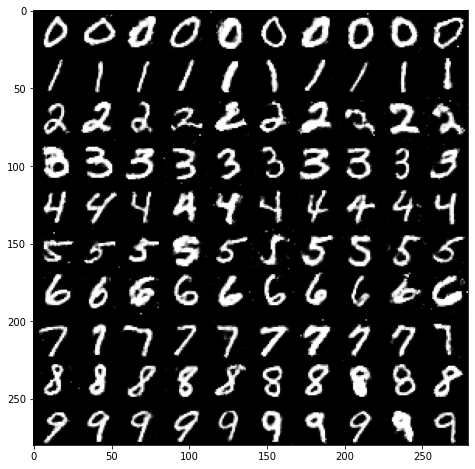

In [ ]:
# generation to image
G.eval()
plt.figure(figsize=(8,8)) 
imshow(get_sample_images(G, num_samples), cmap='gray')

In [ ]:
# Saving params
min_value = min(G_loss_history)
min_index = G_loss_history.index(min_value)
print(min_index)  #to see at which epoch the Generator has te lowest loss

# Saving models at last epoch of training
torch.save(D.state_dict(), PATH_DRIVE + '/training_models/Discriminator/Discriminator.pth')
torch.save(G.state_dict(), PATH_DRIVE + '/training_models/Generator/Generator.pth')

127


### **Loading model using pytorch**

In [ ]:
G.load_state_dict(torch.load(PATH_DRIVE + '/training_models/Generator/G_epoch_149.pth'), strict=False)
G.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

### **Making a gif to see Generator's improvement during training**

frames: 21


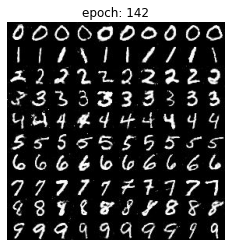

In [ ]:
make_gif(PATH_DRIVE + '/samples/', 300)